# (1): Image Manipulation

This project hinges on our ability to model and remove the bright emission from the circumstellar disk, to have a better chance at finding a faint CPD component hidden in its glare.  Such a model of that emission is itself of great interest to the community, since it will help facilitate comparisons between how this emission varies spatially among different populations of disks.

To develop some intuition about *what* you will be modeling, and *how* you will be doing that, it is important to become familiar with mm/radio images of disks and their general manipulation.  This part of the project should help you learn how to load .FITS data, extract their information, and plot, manipulate, and annotate the images.  This notebook will get you started, and leaves blank cells for you to develop code to achieve various goals.

In [151]:
import os, sys, time           # I basically always load these in every code I write.
import numpy as np             # Numpy is the basic numerics package in Python.
from astropy.io import fits    # .FITS file manipulation package  
import urllib.request          # package for fetching files off the internet
import matplotlib.pyplot as plt    # plotting package
from matplotlib.patches import Ellipse    # plotting package
import cmasher as cmr          # color maps
from astropy.visualization import (AsinhStretch, LogStretch, ImageNormalize)    # image visualization functions
%matplotlib inline                

# disk target name
disk_name = 'DoAr25'

##New target-DoAr25##
# set this to your project directory (or however you like)
working_dir = '/Users/willi/Desktop/Undergraduate Research/'

# if you don't already have the datafile, download it
if not os.path.exists(working_dir+disk_name+'_continuum.fits'):
    dsharp_url = 'https://bulk.cv.nrao.edu/almadata/lp/DSHARP/images/'+disk_name+'_continuum.fits'
    print('Downloading .FITS image...')
    urllib.request.urlretrieve(dsharp_url, working_dir+disk_name+'_continuum.fits')
    print('...Download complete.')
    

# load the .FITS file into a 2-D array (image) and header dictionary (header)
data = fits.open(disk_name+'_continuum.fits')
image = np.squeeze(data[0].data)
header = data[0].header
print(header)    # this shows you what is in the header

...Download complete.
SIMPLE  =                    T /Standard FITS                                   BITPIX  =                  -32 /Floating point (32 bit)                         NAXIS   =                    4                                                  NAXIS1  =                 3000                                                  NAXIS2  =                 3000                                                  NAXIS3  =                    1                                                  NAXIS4  =                    1                                                  EXTEND  =                    T                                                  BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 BZERO   =   0.000000000000E+00                                                  BMAJ    =   1.126681454480E-05                                                  BMIN    =   6.017470214930E-06                                                  BPA     =   7.0447

**(A): Load a .FITS file:**

We will start the project with the disk around the young star [SR 4](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=EM*+SR+4&NbIdent=1&Radius=2&Radius.unit=arcmin&submit=submit+id).  You can download the $\lambda = 1.25$ mm wavelength continuum image from the [DSHARP data repository](https://bulk.cv.nrao.edu/almadata/lp/DSHARP/), and then load the image (a 2-D array) and the header (a dictionary of information about the image) with some standard [Astropy](https://docs.astropy.org/en/stable/) tools.

**(B) Explore the Data Contents:**

Now we can extract some basic information content about the image, primarily from the header dictionary.  First, we want to reconstruct the image coordinate frame, by calculating the RA and DEC of each pixel in the image.  Next, we extract the observing frequency of the image.  And then, we extract the parameters of the "beam", or point-spread function (PSF: the instrumental response that artificially blurs the image spatially -- more on this later).  For mm/radio images, the PSF is an elliptical Gaussian: the header records the full-width at half-maximum (FWHM) along the major and minor axes of that ellipse, as well as the position angle (measured toward the east, starting at north) of the major axis.    

In [2]:
# number of pixels in RA, DEC dimensions
nx, ny = header['NAXIS1'], header['NAXIS2']
print(nx, ny, image.shape)    # can see that these are the same as the array dimensions

# coordinate frames can be reconstructed from a mapping to pixels with header variables
# these 1-D mappings are in **degrees** units
RA = header['CRVAL1'] + header['CDELT1'] * (np.arange(nx) - (header['CRPIX1'] - 1))
DEC = header['CRVAL2'] + header['CDELT2'] * (np.arange(ny) - (header['CRPIX2'] - 1))

# convert these to offsets from the image center, in **arcseconds** units
RAo, DECo = 3600 * (RA - header['CRVAL1']), 3600 * (DEC - header['CRVAL2'])

# shift these coordinates to account for the center of the disk (offRA, offDEC)
offRA, offDEC = -0.0636, -0.5090    # measured in Huang et al. 2018, ApJL, 869, L42
RAo_shift, DECo_shift = RAo - offRA, DECo - offDEC

# now convert these to two-dimensional arrays of RA and DEC offsets from the disk center for each pixel
dRA, dDEC = np.meshgrid(RAo_shift, DECo_shift)


# get the observing frequency (in Hz units)
freq = header['CRVAL3']


# get the beam parameters (in **arcseconds** for the FWHM, and **degrees** for the position angle)
beam_maj, beam_min, beam_PA = 3600 * header['BMAJ'], 3600 * header['BMIN'], header['BPA']

# compute the beam area (in **steradians**)
# trust me...this is tricky, but the first part is the integral of the 2-D gaussian PSF
beam_area = (np.pi * beam_maj * beam_min / (4 * np.log(2))) / (3600 * 180 / np.pi)**2

3000 3000 (3000, 3000)


**(C) Image Visualization:**

Here we will make a basic plot of the image and some standard annotations, to introduce the formatting.  

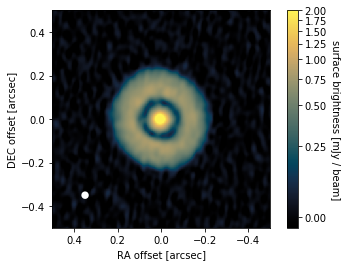

In [6]:
# define the full image boundaries with a list of the min/max RA and DEC offsets
# (note the reverse ordering for RA, since this is plotted with E to the left)
im_bounds = (dRA.max(), dRA.min(), dDEC.min(), dDEC.max())

# now set the RA and DEC offset ranges you want to show
dRA_lims  = [0.5, -0.5]      # (same reverse ordering to ensure E is to the left)
dDEC_lims = [-0.5, 0.5]

# now define the color-map, intensity limits, and stretch
cmap = cmr.eclipse
vmin, vmax = -0.03, 2.0    # these are in mJy/beam units
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())

# set up and plot the image on the specified scale
fig, ax = plt.subplots()
im = ax.imshow(1e3*image, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_label('surface brightness [mJy / beam]', rotation=270, labelpad=13)

# make an ellipse to show the PSF (beam) dimensions, in the lower left corner (its very small!)
beam = Ellipse((dRA_lims[0] + 0.15*np.diff(dRA_lims), dDEC_lims[0] + 0.15*np.diff(dDEC_lims)), 
                beam_maj, beam_min, 90-beam_PA)
beam.set_facecolor('w')
ax.add_artist(beam)

**Activities:**

So, once you have experimented with the code above, there are some useful things to try on your own.  

- Write a python function that takes in the name of a FITS file as its parameter (and we can add keywords as needed), and returns an image 'object' with the attributes {image (the 2-D image array), dRA, dDEC, beam parameters (a tuple of beam_major, beam_minor, beam_PA, and beam_area)}.  A generic pseudo-code illustrates how this works below.  Think about additional keywords you might want to make this more handy.  BONUS: Consider returning a "figure" object if requested, so a plot can be readily made.

- Using your function, remake the image figure above, but this time in "brightness temperatures" (Kelvin units) instead of surface brightnesses (Jy/beam).  The brightness temperature ($T_b$) is just a different way to cast a surface brightness ($I_\nu$).  It is defined such that $I_\nu = B_\nu(T_b)$, where $B_\nu$ denotes the Planck function, which has units of erg / s / cm^2 / Hz / steradian.  Typically, in radio astronomy we use the Rayleigh-Jeans approximation to write $B_\nu \approx 2 \nu^2 k_B T_b / c^2$.  The only real "trick" here is that you have to convert $I_\nu$ from its weird units (Jy / beam means Jansky's per beam area).  The $T_b$ image should provide much more legible units for the scalebar (i.e., something like 0 to 20 K would be fine).     

- Code up the equation of an ellipse to plot on top of the image (you can use the Ellipse function I employed to make the beam to check your work, but do the actual math: it will be useful in the next steps).  The ellipse parameters should be the semimajor axis $a$, the inclination angle $i$ (where $\cos{i} = b/a$, with $b$ the semiminor axis), and the position angle of the major axis (think a simple code of the operation of a [rotation matrix](https://mathworld.wolfram.com/RotationMatrix.html)).  Try and set it up so the ellipse is aligned with the emission gap.  

C:\Users\William\anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


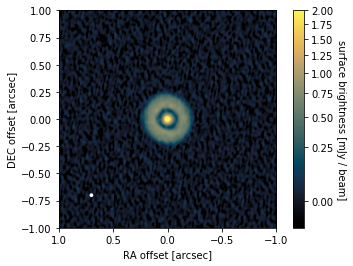

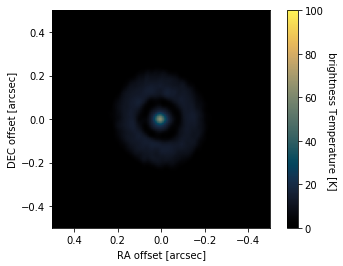

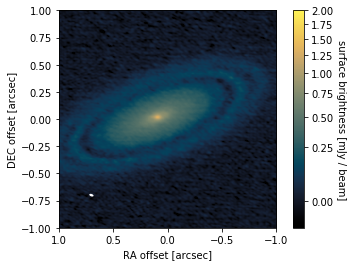

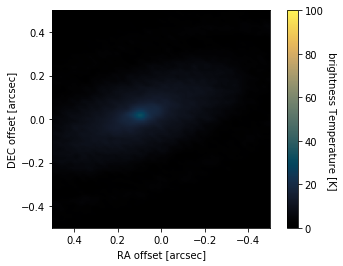

In [8]:
import os, sys, time   
import math # I basically always load these in every code I write.
import numpy as np             # Numpy is the basic numerics package in Python.
from astropy.io import fits    # .FITS file manipulation package  
import urllib.request          # package for fetching files off the internet
import matplotlib.pyplot as plt    # plotting package
from matplotlib.patches import Ellipse    # plotting package
import cmasher as cmr          # color maps
from astropy.visualization import (AsinhStretch, LogStretch, SqrtStretch, ImageNormalize)    # image visualization functions
%matplotlib inline                



# establish an object with some collection of attributes
class my_class:
    def __init__(self,image, dRA, dDEC, beam_maj, beam_min, beam_PA, beam_area, nu):
        self.image = image
        self.dRA = dRA
        self.dDEC = dDEC
        self.nu=nu #frequency#
        self.beam_maj=beam_maj
        self.beam_min=beam_min
        self.beam_PA=beam_PA
        self.beam_area=beam_area
        
        

# an example python function that establishes an object class
def my_function(parameter):
    disk_name=parameter
    data = fits.open(disk_name+'_continuum.fits')
    image = np.squeeze(data[0].data)
    header = data[0].header
    nx, ny = header['NAXIS1'], header['NAXIS2']
    RA = header['CRVAL1'] + header['CDELT1'] * (np.arange(nx) - (header['CRPIX1'] - 1))
    DEC = header['CRVAL2'] + header['CDELT2'] * (np.arange(ny) - (header['CRPIX2'] - 1))
    RAo, DECo = 3600 * (RA - header['CRVAL1']), 3600 * (DEC - header['CRVAL2'])
    offRA, offDEC = -0.0636, -0.5090    # measured in Huang et al. 2018, ApJL, 869, L42
    RAo_shift, DECo_shift = RAo - offRA, DECo - offDEC
    dRA, dDEC = np.meshgrid(RAo_shift, DECo_shift)
    freq = header['CRVAL3']
    nu=(3*10**8)/(1.25*10**(-3))
    beam_maj, beam_min, beam_PA = 3600 * header['BMAJ'], 3600 * header['BMIN'], header['BPA']
    beam_area = (np.pi * beam_maj * beam_min / (4 * np.log(2))) / (3600 * 180 / np.pi)**2
   
    
    # create an object
    my_object = my_class(image, dRA, dDEC, beam_maj, beam_min, beam_PA, beam_area, nu)
    
    return my_object

SR4=my_function('SR4')
DoAr25=my_function('DoAr25')
##TEMPERATURE MAP##




def diskplotter(x):
    im_bounds = (x.dRA.max(), x.dRA.min(), x.dDEC.min(), x.dDEC.max())
    dRA_lims  = [1, -1]      # (same reverse ordering to ensure E is to the left)
    dDEC_lims = [-1, 1]
    cmap = cmr.eclipse
    vmin, vmax = -0.03, 2.0    # these are in mJy/beam units
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SqrtStretch())
    fig, ax = plt.subplots()
    im = ax.imshow(1e3*x.image, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
    ax.set_xlim(dRA_lims)
    ax.set_ylim(dDEC_lims)
    ax.set_xlabel('RA offset [arcsec]')
    ax.set_ylabel('DEC offset [arcsec]')
    cb = plt.colorbar(im, ax=ax, pad=0.05)
    cb.set_label('surface brightness [mJy / beam]', rotation=270, labelpad=13)
    beam = Ellipse((dRA_lims[0] + 0.15*np.diff(dRA_lims), dDEC_lims[0] + 0.15*np.diff(dDEC_lims)), x.beam_maj, x.beam_min, 90-x.beam_PA)
    beam.set_facecolor('w')
    ax.add_artist(beam)


    #####Temperature
    im_bounds = (x.dRA.max(), x.dRA.min(), x.dDEC.min(), x.dDEC.max())
    dRA_lims  = [0.5, -0.5]      # (same reverse ordering to ensure E is to the left)
    dDEC_lims = [-0.5, 0.5]
    def Temp(I,l,A):  ###f-frequency, I-intensity, A-beam area
        g=(l**2)/(2*1.38*10**(-23)*A)*10**(-26)*I ##10^-26 W/m^2/Hz-> 1 Jy
        return g
    T=Temp(x.image, 1.25*10**(-3), x.beam_area)   
    ###The temperatures I'm calculating seem low. 

    normT = ImageNormalize(vmin=0, vmax=100, stretch=AsinhStretch())
    fig2, ax2 = plt.subplots()
    im2 = ax2.imshow(T, origin='lower', cmap=cmap, extent=im_bounds, vmin=0, vmax=100, aspect='equal')
    ax2.set_xlim(dRA_lims)
    ax2.set_ylim(dDEC_lims)
    ax2.set_xlabel('RA offset [arcsec]')
    ax2.set_ylabel('DEC offset [arcsec]')
    cb = plt.colorbar(im2, ax=ax2, pad=0.05)
    cb.set_label(' brightness Temperature [K]', rotation=270, labelpad=13)
diskplotter(SR4)
diskplotter(DoAr25)

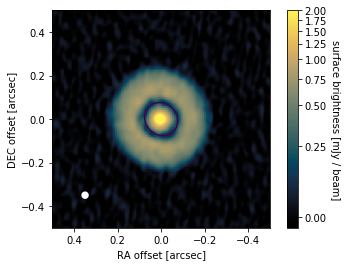

In [148]:
import os, sys, time   
import math # I basically always load these in every code I write.
import numpy as np             # Numpy is the basic numerics package in Python.
from astropy.io import fits    # .FITS file manipulation package  
import urllib.request          # package for fetching files off the internet
import matplotlib.pyplot as plt    # plotting package
from matplotlib.patches import Ellipse    # plotting package
import cmasher as cmr          # color maps
from astropy.visualization import (AsinhStretch, LogStretch, ImageNormalize)

#####Ellipse####
###a-semimajor axis, i-inclination, t-angle of rotation,h,k-center

                                   
                                   
def ellipseplot(a, i, t, h, k):
    x = -np.linspace(-1,1,2000)
    y = np.linspace(-1,1,2000)
    Z=1
    Z_2=h
    Z_3=k
    Z_4=a
    Z_5=a*math.cos(i)
    
    X,Y = np.meshgrid(x,y)
    eqn=((X-h)*math.cos(t)+(Y-k)*math.sin(t))**2/(a**2)+((X-h)*math.sin(t)-(Y-k)*math.cos(t))**2/((a*math.cos(i))**2)
    eqn2=X
    eqn3=Y
    plt.contour(X,Y,eqn,[Z])

im_bounds = (SR4.dRA.max(), SR4.dRA.min(), SR4.dDEC.min(), SR4.dDEC.max())
dRA_lims  = [0.5, -0.5]      # (same reverse ordering to ensure E is to the left)
dDEC_lims = [-0.5, 0.5]
cmap = cmr.eclipse
vmin, vmax = -0.03, 2.0    # these are in mJy/beam units
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())
fig, ax = plt.subplots()
im = ax.imshow(1e3*SR4.image, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_label('surface brightness [mJy / beam]', rotation=270, labelpad=13)
beam = Ellipse((dRA_lims[0] + 0.15*np.diff(dRA_lims), dDEC_lims[0] + 0.15*np.diff(dDEC_lims)), SR4.beam_maj, SR4.beam_min, 90-SR4.beam_PA)
beam.set_facecolor('w')
ax.add_artist(beam)
ellipseplot(0.08, math.pi/7, -3*math.pi/4, 0, 0)

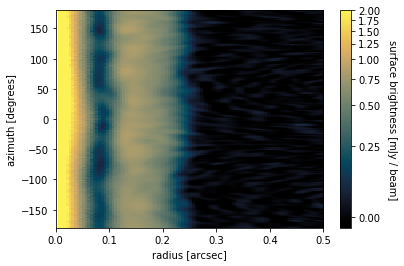

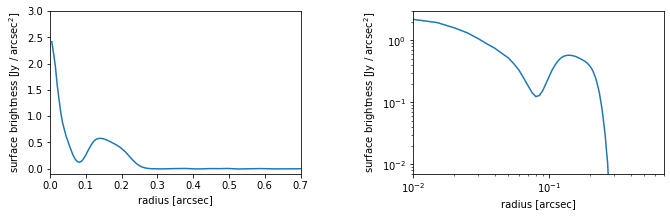

In [11]:
########PART2: Radial Emission Profile#####

import os, sys, time           # I basically always load these in every code I write.
import numpy as np             # Numpy is the basic numerics package in Python.
from astropy.io import fits    # .FITS file manipulation package  
import urllib.request          # package for fetching files off the internet
import matplotlib.pyplot as plt    # plotting package
from scipy.interpolate import interp1d    # 1-dimensional interpolation package   
from matplotlib.patches import Ellipse    # simple ellipse plotting utility
import cmasher as cmr          # color maps
from astropy.visualization import (AsinhStretch, LogStretch, ImageNormalize)    # image visualization packages
from skimage import transform, measure    # some tools to rotation and stretch images
from scipy.ndimage.interpolation import shift    # tool for image interpolation
%matplotlib inline                

# set the inclination and PA of the disk onto the sky-frame
    #incl, PA = 24.2, 43.7   # these were measured by the DSHARP consortium (Huang et al. 2018, ApJL, 869, L42 - Table 2)
def radialplotter(x, i_1, p_1, n):
    disk_name=n
    incl, PA=i_1, p_1
    # convert these to radius
    inclr, PAr = np.radians(incl), np.radians(PA)

    # deproject and rotate to new coordinate frame
    xp = (x.dRA * np.cos(PAr) - x.dDEC * np.sin(PAr)) / np.cos(inclr)
    yp = (x.dRA * np.sin(PAr) + x.dDEC * np.cos(PAr))

    # now convert to polar coordinates (r in arcseconds, theta in degrees)
    # note that theta starts along the minor axis (theta = 0), and rotates clockwise in the sky plane)
    r = np.sqrt(xp**2 + yp**2)
    theta = np.degrees(np.arctan2(yp, xp))

    # radius and azimuth bin centers (and their widths)
    rbins = np.linspace(0.005, 1.5, 300)    # in arcseconds
    tbins = np.linspace(-180, 180, 181)     # in degrees
    dr = np.abs(rbins[1] - rbins[0])
    dt = np.abs(tbins[1] - tbins[0])

    # initialize the (r, az)-map and radial profile
    rtmap = np.empty((len(tbins), len(rbins)))
    SBr, err_SBr = np.empty(len(rbins)), np.empty(len(rbins))

    # loop through the bins to populate the (r, az)-map and radial profile
    for i in range(len(rbins)):
        # identify pixels that correspond to the radial bin (i.e., in this annulus)
        in_annulus = ((r >= (rbins[i] - 0.5 * dr)) & (r < (rbins[i] + 0.5 * dr)))

        # accumulate the azimuth values and surface brightness values in this annulus
        az_annulus = theta[in_annulus]
        SB_annulus = x.image[in_annulus]

        # average the intensities (and their scatter) in the annulus
        SBr[i], err_SBr[i] = np.average(SB_annulus), np.std(SB_annulus)

        # populate the azimuthal bins for the (r, az)-map at this radius
        for j in range(len(tbins)):
            # identify pixels that correspond to the azimuthal bin
            in_wedge = ((az_annulus >= (tbins[j] - 0.5 * dt)) & (az_annulus < (tbins[j] + 0.5 * dt)))

            # if there are pixels in that bin, average the corresponding intensities
            if (len(SB_annulus[in_wedge]) > 0):
                rtmap[j,i] = np.average(SB_annulus[in_wedge])
            else:
                rtmap[j,i] = -1e10    # this is a temporary placeholder; it will be fixed in next piece of code

    # now "fix" the (r, az)-map where there are too few pixels in certain az bins (inner disk)
    # its ok if this part is a "black box": it is not important / relevant
    for i in range(len(rbins)):
        # extract an azimuthal slice of the (r, az)-map
        az_slice = rtmap[:,i]

        # identify if there's missing information in an az bin along that slice:
        # if so, fill it in with linear interpolation along the slice
        if np.any(az_slice < -1e5):
            # extract non-problematic bins in the slice
            x_slice, y_slice = tbins[az_slice >= -1e5], az_slice[az_slice >= -1e5]

            # pad the arrays to make sure they span a full circle in azimuth
            x_slice_ext = np.pad(x_slice, 1, mode='wrap')
            x_slice_ext[0] -= 360.
            x_slice_ext[-1] += 360.
            y_slice_ext = np.pad(y_slice, 1, mode='wrap')

            # define the interpolation function
            raz_func = interp1d(x_slice_ext, y_slice_ext, bounds_error=True)

            # interpolate and replace those bins in the (r, az)-map
            fixed_slice = raz_func(tbins)
            rtmap[:,i] = fixed_slice
##########Radial Plot
# define the full (r, az)-map boundaries with a list of the min/max (r, az) bins
    rtmap_bounds = (rbins.min(), rbins.max(), tbins.min(), tbins.max())

    # set the radius and azimuth ranges you want to show
    t_lims = [-180, 180]      
    r_lims = [0, 0.5]

    # now define the color-map, intensity limits, and stretch
    cmap = cmr.eclipse
    vmin, vmax = -0.03, 2    # these are in mJy/beam units
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())

    # set up and plot the image on the specified scale
    fig, ax = plt.subplots()
    im = ax.imshow(1e3*rtmap, origin='lower', cmap=cmap, extent=rtmap_bounds, norm=norm, aspect='auto')
    ax.set_xlim(r_lims)
    ax.set_ylim(t_lims)
    ax.set_ylabel('azimuth [degrees]')
    ax.set_xlabel('radius [arcsec]')

    # add a scalebar
    cb = plt.colorbar(im, ax=ax, pad=0.05)
    cb.set_label('surface brightness [mJy / beam]', rotation=270, labelpad=17)
    
    ###Averaged 1D radial plots 
    
     # convert from Jy / beam --> Jy / arcsec**2
    SBr_0 = SBr / (x.beam_area * (3600 * 180 / np.pi)**2)
    err_SBr_0 = err_SBr / (x.beam_area * (3600 * 180 / np.pi)**2)

    # let's save this profile into a text (ASCII) file for later use
    prof = list(zip(rbins, SBr_0, err_SBr_0))
    np.savetxt(disk_name+'_cleanSBr.txt', prof, fmt='%.6e', header='rarcsec, SBr, err_SBr')

    # set up the plots
    fig, axs = plt.subplots(ncols=2, figsize=(11,3))

    # the profile on a linear scaling
    ax = axs[0]
    ax.plot(rbins, SBr_0)
    ax.set_xlim([0, 0.7])
    ax.set_ylim([-0.1, 3])
    ax.set_xlabel('radius [arcsec]')
    ax.set_ylabel('surface brightness [Jy / arcsec$^2$]')

    # the profile on a logarithmic scaling
    ax = axs[1]
    ax.plot(rbins, SBr_0)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([0.01, 0.7])
    ax.set_ylim([0.007, 3])
    ax.set_xlabel('radius [arcsec]')
    ax.set_ylabel('surface brightness [Jy / arcsec$^2$]')

    # helps separate the plots
    fig.subplots_adjust(wspace=0.45)   
    ###Create an object####
    class radclass:
        def __init__(self, rtmap, SBr_0, rbins, err_SBr_0):
            self.rtmap=rtmap
            self.SBr_0=SBr_0
            self.rbins=rbins
            self.err_SBr_0=err_SBr_0
    my_object = radclass(rtmap, SBr_0, rbins, err_SBr_0)
    
    return my_object
#incl, PA = 24.2, 43.7   # these were measured by the DSHARP consortium (Huang et al. 2018, ApJL, 869, L42 - Table 2)
SR4_rad=radialplotter(SR4, 24.2, 43.7, 'SR4')

            
    
    
    

C:\Users\William\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


[2.30904563e+00 5.78244268e-01 2.18295319e+02 7.59963458e+02
 1.53961364e-01]


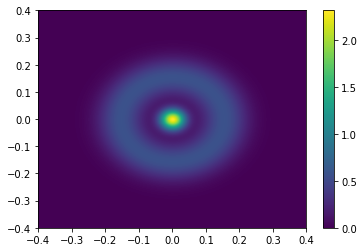

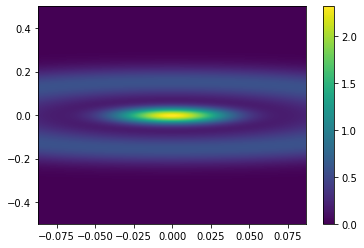

In [44]:
#####BEST FIT PLOT####
import pandas as pd
from pandas import DataFrame
from  scipy import optimize 
def fit_function(x, A, B, b, a, c):
    return A*np.exp(-a*x**2)+B*np.exp(-b*(x-c)**2)

params, param_cov=optimize.curve_fit(fit_function, SR4_rad.rbins, SR4_rad.SBr_0, p0=[2.5, 0.5, 0.01, 10, 0.15])
print(params)
def diskcreator():
    x = np.linspace(-0.4,0.4,2000)
    y = np.linspace(-0.4,0.4,2000)
    X,Y = np.meshgrid(x,y)
    R=np.sqrt(X**2+Y**2)
    Z=fit_function(R, params[0], params[1],params[2], params[3], params[4])
    plt.pcolormesh(X,Y, Z)
    plt.colorbar()
    plt.show()
    
    
   
diskcreator() 
def ediskcreator(PA,inc):

    x = np.linspace(-0.5,0.5,2000)
    y = np.linspace(-0.5,0.5,2000)
    X,Y = np.meshgrid(x,y)
    incl=np.radians(inc)
    p=math.cos(incl)
    Xn=p*X
    R=np.sqrt(Xn**2+Y**2)
    Z=fit_function(R, params[0], params[1],params[2], params[3], params[4])
    plt.pcolormesh(Xn,Y, Z)
    plt.colorbar()
    plt.show()
ediskcreator(0, 80)  

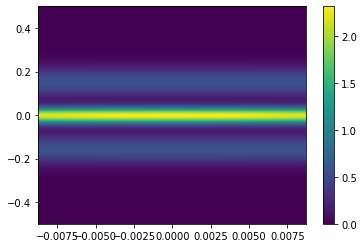

In [45]:
ediskcreator(0, 89) 

In [20]:
x = -np.linspace(-0.4,0.4,2000)
y = np.linspace(-0.4,0.4,2000)
X,Y = np.meshgrid(x,y)
print(X)

[[ 0.4        0.3995998  0.3991996 ... -0.3991996 -0.3995998 -0.4      ]
 [ 0.4        0.3995998  0.3991996 ... -0.3991996 -0.3995998 -0.4      ]
 [ 0.4        0.3995998  0.3991996 ... -0.3991996 -0.3995998 -0.4      ]
 ...
 [ 0.4        0.3995998  0.3991996 ... -0.3991996 -0.3995998 -0.4      ]
 [ 0.4        0.3995998  0.3991996 ... -0.3991996 -0.3995998 -0.4      ]
 [ 0.4        0.3995998  0.3991996 ... -0.3991996 -0.3995998 -0.4      ]]


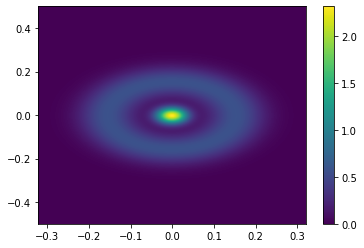

In [46]:
ediskcreator(0, 50)  

In [13]:

####Interferometry####





import os, sys, time           # I basically always load these in every code I write.
import numpy as np             # Numpy is the basic numerics package in Python.
from astropy.io import fits    # .FITS file manipulation package  
import urllib.request          # package for fetching files off the internet
import matplotlib.pyplot as plt    # plotting package
import cmasher as cmr          # color maps
%matplotlib inline
disk_name='SR4'
working_dir = '/Users/William/Desktop/Undergraduate Research/'
if not os.path.exists(working_dir+disk_name+'_continuum_tbin60s_SPWavg.vis.npz'):
    dsharp_url = 'http://www.cfa.harvard.edu/~sandrews/data/'+disk_name+'_continuum_tbin60s_SPWavg.vis.npz'
    print('Downloading VISIBILITY data...')
    urllib.request.urlretrieve(dsharp_url, working_dir+disk_name+'_continuum_tbin60s_SPWavg.vis.npz')
    print('...Download complete.')

# load the visibility data
dat = np.load(disk_name+'_continuum_tbin60s_SPWavg.vis.npz')
u, v, vis, wgt = dat['u'], dat['v'], dat['Vis'], dat['Wgt']

# create a visibility data class and use it to package up the data neatly
class Visibility:
    def __init__(self, vis, u, v, wgt):
        self.vis = vis 
        self.u = u 
        self.v = v 
        self.wgt = wgt
datavis = Visibility(vis, u, v, wgt)



11269383.327054368 11009.733204845184
9.082872231271854e-05 8.873600009676693e-08


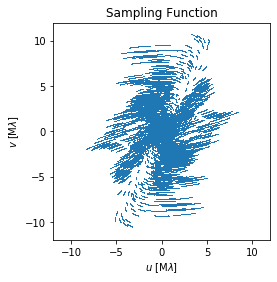

In [14]:
import os, sys, time           # I basically always load these in every code I write.
import numpy as np             # Numpy is the basic numerics package in Python.
from astropy.io import fits    # .FITS file manipulation package  
import urllib.request          # package for fetching files off the internet
import matplotlib.pyplot as plt    # plotting package
import cmasher as cmr          # color maps
%matplotlib inline
disk_name='SR4'



dat = np.load(disk_name+'_continuum_tbin60s_SPWavg.vis.npz')
u, v, vis, wgt = dat['u'], dat['v'], dat['Vis'], dat['Wgt']

# create a visibility data class and use it to package up the data neatly
class Visibility:
    def __init__(self, vis, u, v, wgt):
        self.vis = vis 
        self.u = u 
        self.v = v 
        self.wgt = wgt
datavis = Visibility(vis, u, v, wgt)




fig, axs = plt.subplots()
ax = axs
ax.plot(datavis.u * 1e-6, datavis.v * 1e-6, ',C0')
ax.plot(-datavis.u * 1e-6, -datavis.v * 1e-6, ',C0')
ax.set_aspect('equal')
ax.set_xlim([-12, 12])
ax.set_xlabel('$u$ [M$\\lambda$]')
ax.set_ylim([-12, 12])
ax.set_ylabel('$v$ [M$\\lambda$]')
ax.set_title('Sampling Function')



d=np.sqrt(datavis.u**2+datavis.v**2)
dmax=np.amax(d)
dmin=np.amin(d)
print(dmax, dmin)
#####Angular scales 
l=(3*10**8)/(240*10**6)
thmax=1/dmin
thmin=1/dmax
print(thmax, thmin)




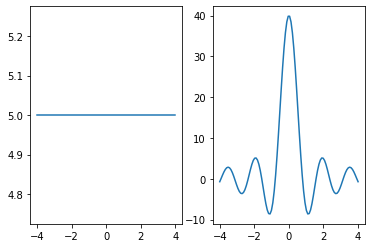

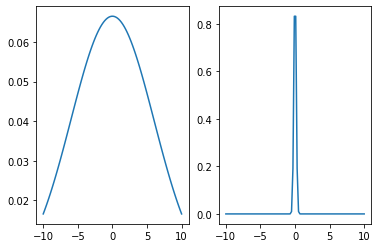

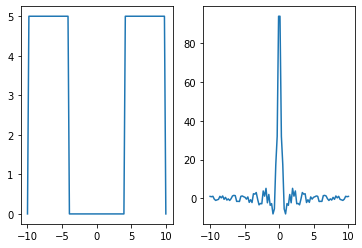

In [67]:
def FTplot1(C,x1):
    x=np.linspace(-x1,x1, 100)
    y=np.repeat(C,100)
    f=2*C/x*np.sin(x*x1)
    fig, (ax1, ax2)= plt.subplots(1,2)
    ax1.plot(x,y)
    ax2.plot(x,f)
FTplot(5,4)
def FTplot2(C):
    x=np.linspace(-10,10, 100)
    y=1/(math.sqrt(2*math.pi*C**2))*np.exp((-x**2)/(2*C**2))
    f=np.exp((-C**2*x**2)/2)
    fig, (ax1, ax2)= plt.subplots(1,2)
    ax1.plot(x,y)
    ax2.plot(x,f)

FTplot2(6)

def FTplot3(C, x1, x2):
    x=np.linspace(-x2,x2, 100)
    w=np.linspace(-10, 10, 100)
    y=np.piecewise(x, [(x>-x2) &(x<-x1), (x>=-x1) & (x<x1), (x>=x1) & (x<x2)],  [C, 0, C])
    f=2*C/w*(np.sin(w*x1+np.sin(w*x2)))
    fig, (ax1, ax2)= plt.subplots(1,2)
    ax1.plot(x,y)
    ax2.plot(w,f)
FTplot3(5, 4, 10)






Text(0, 0.5, 'imag($\\mathcal{V}$) [mJy]')

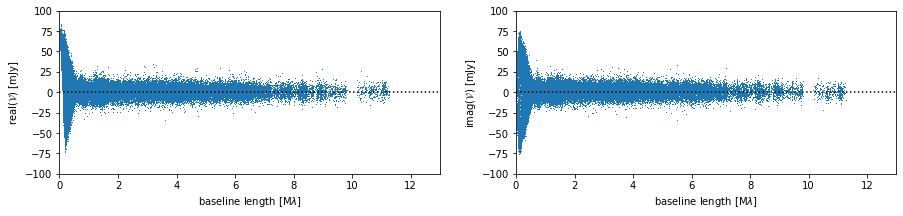

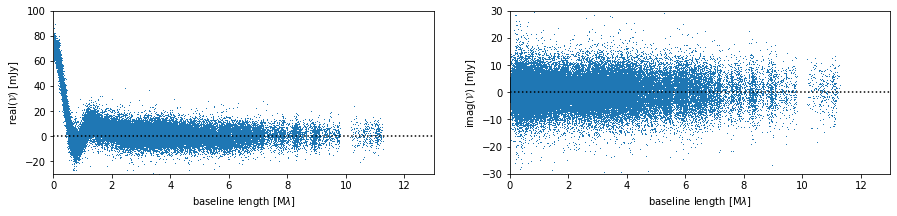

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 3))
ax = axs[0]
ax.plot(np.sqrt(datavis.u**2 + datavis.v**2) * 1e-6, 1e3 * datavis.vis.real, ',C0')
ax.plot([0, 15], [0, 0], ':k')
ax.set_xlim([0, 13])
ax.set_xlabel('baseline length [M$\\lambda$]')
ax.set_ylim([-100, 100])
ax.set_ylabel('real($\mathcal{V}$) [mJy]')

ax = axs[1]
ax.plot(np.sqrt(datavis.u**2 + datavis.v**2) * 1e-6, 1e3 * datavis.vis.imag, ',C0')
ax.plot([0, 15], [0, 0], ':k')
ax.set_xlim([0, 13])
ax.set_xlabel('baseline length [M$\\lambda$]')
ax.set_ylim([-100, 100])
ax.set_ylabel('imag($\mathcal{V}$) [mJy]')


#####offset correction####
# phase shifts to account for offsets
offRA, offDEC = -0.060, -0.509
offx, offy = -offRA * np.pi / (180 * 3600), -offDEC * np.pi / (180 * 3600)
pshift = np.exp(-2 * np.pi * 1.0j * (datavis.u*-offx + datavis.v*-offy))
shifted_vis = datavis.vis * pshift

fig, axs = plt.subplots(ncols=2, figsize=(15, 3))
ax = axs[0]
ax.plot(np.sqrt(datavis.u**2 + datavis.v**2) * 1e-6, 1e3 * shifted_vis.real, ',C0')
ax.plot([0, 15], [0, 0], ':k')
ax.set_xlim([0, 13])
ax.set_xlabel('baseline length [M$\\lambda$]')
ax.set_ylim([-30, 100])
ax.set_ylabel('real($\mathcal{V}$) [mJy]')

ax = axs[1]
ax.plot(np.sqrt(datavis.u**2 + datavis.v**2) * 1e-6, 1e3 * shifted_vis.imag, ',C0')
ax.plot([0, 15], [0, 0], ':k')
ax.set_xlim([0, 13])
ax.set_xlabel('baseline length [M$\\lambda$]')
ax.set_ylim([-30, 30])
ax.set_ylabel('imag($\mathcal{V}$) [mJy]')

In [7]:
import os, sys, time           # I basically always load these in every code I write.
import numpy as np             # Numpy is the basic numerics package in Python.
from astropy.io import fits    # .FITS file manipulation package  
import urllib.request          # package for fetching files off the internet
import matplotlib.pyplot as plt    # plotting package
from matplotlib.patches import Ellipse    # plotting package
import cmasher as cmr          # color maps
from astropy.visualization import (AsinhStretch, LogStretch, ImageNormalize)    # image visualization functions
%matplotlib inline                

# disk target name
disk_name = 'SR4'

# set this to your project directory (or however you like)
working_dir = '/Users/William/Desktop/Undergraduate Research/'

# if you don't already have the datafiles, download them
if not os.path.exists(working_dir+disk_name+'_continuum.model.fits'):
    dsharp_url = 'http://www.cfa.harvard.edu/~sandrews/data/'+disk_name+'_continuum.model.fits'
    print('Downloading .FITS image...')
    urllib.request.urlretrieve(dsharp_url, working_dir+disk_name+'_continuum.model.fits')
    print('...Download complete.')
if not os.path.exists(working_dir+disk_name+'_continuum.psf.fits'):
    dsharp_url = 'http://www.cfa.harvard.edu/~sandrews/data/'+disk_name+'_continuum.psf.fits'
    print('Downloading .FITS image...')
    urllib.request.urlretrieve(dsharp_url, working_dir+disk_name+'_continuum.psf.fits')
    print('...Download complete.')
if not os.path.exists(working_dir+disk_name+'_continuum.residuals.fits'):
    dsharp_url = 'http://www.cfa.harvard.edu/~sandrews/data/'+disk_name+'_continuum.residual.fits'
    print('Downloading .FITS image...')
    urllib.request.urlretrieve(dsharp_url, working_dir+disk_name+'_continuum.residual.fits')
    print('...Download complete.')
if not os.path.exists(working_dir+disk_name+'_continuum.dirty.fits'):
    dsharp_url = 'http://www.cfa.harvard.edu/~sandrews/data/'+disk_name+'_continuum.dirty.fits'
    print('Downloading .FITS image...')
    urllib.request.urlretrieve(dsharp_url, working_dir+disk_name+'_continuum.dirty.fits')
    print('...Download complete.')

...Download complete.
...Download complete.
...Download complete.
...Download complete.


In [ ]:
###Clean based deconvolution, using numpy####


def overlapIndices(a1, a2, shiftx, shifty):
    if shiftx >=0:
        a1xbeg=shiftx
        a2xbeg=0
        a1xend=a1.shape[0]
        a2xend=a1.shape[0]-shiftx
    else:
        a1xbeg=0
        a2xbeg=-shiftx
        a1xend=a1.shape[0]+shiftx
        a2xend=a1.shape[0]

    if shifty >=0:
        a1ybeg=shifty
        a2ybeg=0
        a1yend=a1.shape[1]
        a2yend=a1.shape[1]-shifty
    else:
        a1ybeg=0
        a2ybeg=-shifty
        a1yend=a1.shape[1]+shifty
        a2yend=a1.shape[1]

    return (a1xbeg, a1xend, a1ybeg, a1yend), (a2xbeg, a2xend, a2ybeg, a2yend)

        

def hogbom(dirty, psf, window,gain,thresh, niter):

    comps=numpy.zeros(dirty.shape)
    res=numpy.array(dirty)
    if window is True:
        window=numpy.ones(dirty.shape,
                          numpy.bool)
    for i in range(niter):
        mx, my=numpy.unravel_index(numpy.fabs(res[window]).argmax(), res.shape)
        mval=res[mx, my]*gain
        comps[mx, my]+=mval
        a1o, a2o=overlapIndices(dirty, psf,
                                mx-dirty.shape[0]/2,
                                my-dirty.shape[1]/2)
        res[a1o[0]:a1o[1],a1o[2]:a1o[3]]-=psf[a2o[0]:a2o[1],a2o[2]:a2o[3]]*mval
        if numpy.fabs(res).max() < thresh:
            break
    return comps, res

In [23]:
###deprojection###

def deproject_vis(data, bins=np.array([0]), incl=0., PA=0., offx=0., offy=0., errtype='mean'):
    
    # unpack the data
    u, v, vis, wgt = data
    
    # convert keywords into relevant units
    inclr = np.radians(incl)
    PAr = 0.5 * np.pi - np.radians(PA)
    offx *= -np.pi / (180 * 3600)
    offy *= -np.pi / (180 * 3600)

    # change to a deprojected, rotated coordinate system
    uprime = (u * np.cos(PAr) + v * np.sin(PAr))
    vprime = (-u * np.sin(PAr) + v * np.cos(PAr)) * np.cos(inclr)
    rhop = np.sqrt(uprime**2 + vprime**2)

    # phase shifts to account for offsets
    shifts = np.exp(-2 * np.pi * 1.0j * (u*-offx + v*-offy))
    visp = vis * shifts
    realp = visp.real
    imagp = visp.imag

    # if requested, return a binned (averaged) representation
    if (bins.size > 1):
        avbins = 1e3 * bins       # scale to lambda units (input in klambda)
        bwid = 0.5 * (avbins[1] - avbins[0])
        bvis = np.zeros_like(avbins, dtype='complex')
        berr = np.zeros_like(avbins, dtype='complex')
        for ib in np.arange(len(avbins)):
            inb = np.where((rhop >= avbins[ib] - bwid) & (rhop < avbins[ib] + bwid))
            if (len(inb[0]) >= 5):
                bRe, eRemu = np.average(realp[inb], weights=wgt[inb], returned=True)
                eRese = np.std(realp[inb])
                bIm, eImmu = np.average(imagp[inb], weights=wgt[inb], returned=True)
                eImse = np.std(imagp[inb])
                bvis[ib] = bRe + 1j*bIm
                if (errtype == 'scat'):
                    berr[ib] = eRese + 1j*eImse
                else: berr[ib] = 1 / np.sqrt(eRemu) + 1j / np.sqrt(eImmu)
            else:
                bvis[ib] = 0 + 1j*0
                berr[ib] = 0 + 1j*0
        parser = np.where(berr.real != 0)
        output = avbins[parser], bvis[parser], berr[parser]
        return output
    
    # if not, returned the unbinned representation
    output = rhop, realp + 1j*imagp, 1 / np.sqrt(wgt)

    return output

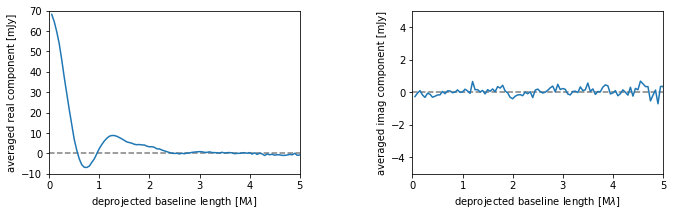

In [24]:
 #the geometric inputs (this must be the same as used to make the profile!)
incl, PA = 24.2, 43.7
offRA, offDEC = -0.0636, -0.5090

# decide on the bins in (u,v)-distance for the profile, in kilo-lambda units
uvbins = np.arange(50, 13020, 50)

# generate the deprojected visibility profile
rho_dat, Vrho_dat, err_Vrho = deproject_vis([u, v, vis, wgt], bins=uvbins, incl=incl, PA=PA, offx=offRA, offy=offDEC)

# plot it!
fig, axs = plt.subplots(ncols=2, figsize=(11,3))
ax = axs[0]
ax.plot([0, 10], [0, 0], '--k', alpha=0.5)
ax.plot(rho_dat * 1e-6, Vrho_dat.real * 1e3)
ax.set_xlim([0, 5])
ax.set_xlabel('deprojected baseline length [M$\\lambda$]')
ax.set_ylim([-10, 70])
ax.set_ylabel('averaged real component [mJy]')

ax = axs[1]
ax.plot([0, 10], [0, 0], '--k', alpha=0.5)
ax.plot(rho_dat * 1e-6, Vrho_dat.imag * 1e3)
ax.set_xlim([0, 5])
ax.set_xlabel('deprojected baseline length [M$\\lambda$]')
ax.set_ylim([-5, 5])
ax.set_ylabel('averaged imag component [mJy]')
fig.subplots_adjust(wspace=0.45)


In [28]:
# pre-define the radius bins you'll compute SB profile models on
b = np.arange(0.003, 0.453, 0.003)     # bin outer edges
a = np.roll(b, 1)                      # bin inner edges
rin = 0.1/140.                         # innermost bin's inner edge
a[0] = rin
rbin_centers = 0.5*(a+b)               # bin centers
rbin_edges = rin, b

def SB_model(pars, rbins):
        
    # parse the parameter values
    peakcore = pars[0]   # core component peak brightness (at center) in Jy / arcsec**2
    sig_core = pars[1]   # standard deviation (width) of core in arcseconds
    peakring = pars[2]   # ring component peak brightness in Jy / arcsec**2
    rring = pars[3]      # mean position of ring in arcseconds
    sig_ring = pars[4]
    core_2=pars[5]
    ring_2=pars[6]
    # standard deviation (width) of ring in arcseconds
    
    # compute the core intensity profile
    Inu_core = peakcore * (0.5*np.exp(-0.5 * (rbins / sig_core)**2)+0.5*np.exp(-0.5*(rbins/core_2)**2))
    
    # compute the ring intensity profile
    Inu_ring = peakring * (0.5*np.exp(-0.5 * ((rbins - rring) / sig_ring)**2)+0.5*np.exp(-0.5* ((rbins - rring) / ring_2)**2))
    
    return (Inu_core + Inu_ring)

In [26]:
import scipy.special as sfunc

def vis_model(SB, rbins, pars, incl=0, PA=0, offRA=0, offDEC=0):

    # parse the geometric parameters (into radian units)
    inclr = np.radians(incl)
    PAr = 0.5 * np.pi - np.radians(PA)
    dx = offRA * np.pi / (180 * 3600)
    dy = offDEC * np.pi / (180 * 3600)
    
    # coordinate change to deal with projection and rotation
    uprime = u * np.cos(PAr) + v * np.sin(PAr)
    vprime = (-u * np.sin(PAr) + v * np.cos(PAr)) * np.cos(inclr)
    
    # deprojected baseline lengths
    rho = np.sqrt(uprime**2 + vprime**2) * np.pi / (180 * 3600)

    # re-orient the array of outer edges for the radius bins
    rin, b = rbins
    rbin = np.concatenate([np.array([rin]), b])

    # compute the matrix of jinc functions (Nvis x Nbins)
    jarg = np.outer(2 * np.pi * rbin, rho)
    jinc_matrix = sfunc.j1(jarg) / jarg

    # re-orient array of (binned) surface brightnesses
    Ibin = np.append(np.concatenate([np.array([0.0]), SB]), 0.)
    II = Ibin - np.roll(Ibin, -1)
    intensity = np.delete(II, SB.size)
    
    # compute the visibilities (a summation of Hankel transforms for each intensity annulus)
    vis = np.dot(2 * np.pi * rbin**2 * intensity, jinc_matrix)

    # impart a phase center shift
    shift = np.exp(-2 * np.pi * 1.0j * ((u * -dx) + (v * -dy)))    
    mvis = vis * shift

    return mvis

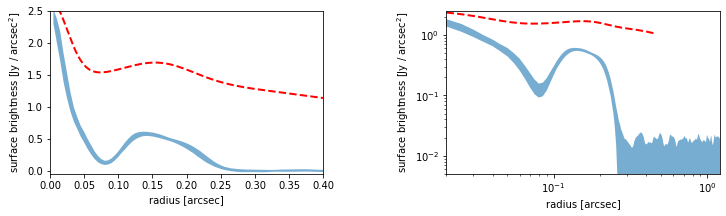

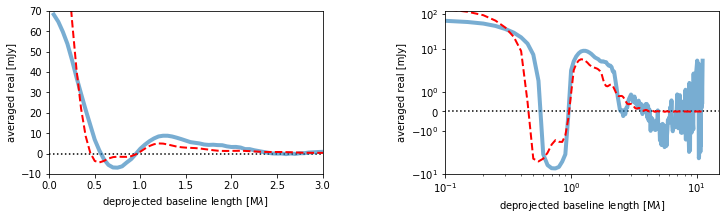

In [35]:
# surface brightness model
pars = [2.4, 0.025, 0.55, 0.16, 0.05, 0.04,]
model_Inu = SB_model(pars, rbin_centers)

# 1-D convolution kernel
from astropy.convolution import Gaussian1DKernel, convolve
sig_beam = np.sqrt(SR4.beam_maj * SR4.beam_min) / (2 * np.sqrt(2 * np.log(2)))
psf = Gaussian1DKernel(stddev=sig_beam / np.mean(np.diff(rbin_centers[1:])))
Inu_model_conv = convolve(model_Inu, psf, boundary='extend')

# visibility model
model_FT = vis_model(model_Inu, rbin_edges, pars, incl=incl, PA=PA, offRA=offRA, offDEC=offDEC)
rho_model, Vrho_model, ign = deproject_vis([u, v, model_FT, wgt], bins=uvbins,
                                           incl=incl, PA=PA, offx=offRA, offy=offDEC)


fig, axs = plt.subplots(ncols=2, figsize=(12,3))

ax = axs[0]
ax.fill_between(SR4_rad.rbins, SR4_rad.SBr_0-SR4_rad.err_SBr_0, SR4_rad.SBr_0+SR4_rad.err_SBr_0, alpha=0.6)
ax.set_xlim([0.0, 0.4])
ax.set_ylim([-0.05, 2.5])
ax.set_xlabel('radius [arcsec]')
ax.set_ylabel('surface brightness [Jy / arcsec$^2$]')
ax.plot(rbin_centers, model_Inu, '--r', lw=2)

ax = axs[1]
ax.fill_between(SR4_rad.rbins, SR4_rad.SBr_0-SR4_rad.err_SBr_0, SR4_rad.SBr_0+SR4_rad.err_SBr_0, alpha=0.6)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.02, 1.2])
ax.set_ylim([0.005, 2.5])
ax.set_xlabel('radius [arcsec]')
ax.set_ylabel('surface brightness [Jy / arcsec$^2$]')
ax.plot(rbin_centers, model_Inu, '--r', lw=2)

fig.subplots_adjust(wspace=0.45)


# visibility profiles
fig, axs = plt.subplots(ncols=2, figsize=(12,3))

ax = axs[0]
ax.plot([0, 15], [0, 0], ':k')
ax.plot(rho_dat * 1e-6, Vrho_dat.real * 1e3, alpha=0.6, lw=4)
ax.set_xlim([0, 3])
ax.set_xlabel('deprojected baseline length [M$\\lambda$]')
ax.set_ylim([-10, 70])
ax.set_ylabel('averaged real [mJy]')
ax.plot(rho_model * 1e-6, Vrho_model.real * 1e3, '--r', lw=2)

ax = axs[1]
ax.plot([0, 15], [0, 0], ':k')
ax.plot(rho_dat * 1e-6, Vrho_dat.real * 1e3, alpha=0.6, lw=4)
ax.set_xlim([0.1, 15])
ax.set_xscale('log')
ax.set_xlabel('deprojected baseline length [M$\\lambda$]')
ax.set_ylim([-10, 125])
ax.set_yscale('symlog')
ax.set_ylabel('averaged real [mJy]')
ax.plot(rho_model * 1e-6, Vrho_model.real * 1e3, '--r', lw=2)

fig.subplots_adjust(wspace=0.45)